In [6]:
# Import numerical calculation library
import numpy as np
from numpy import pi
import random

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, assemble, transpile, execute, QuantumRegister, ClassicalRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector

In [7]:
# Ejecuta un circuito cuántico 'times' veces
def execute_circuit(qc, times = 1):
    simulator = Aer.get_backend('aer_simulator')
    qc_transpiled = transpile(qc, simulator)
    result = simulator.run(qc_transpiled, shots=times).result()
    counts = result.get_counts(qc_transpiled)
    return counts

# BB84

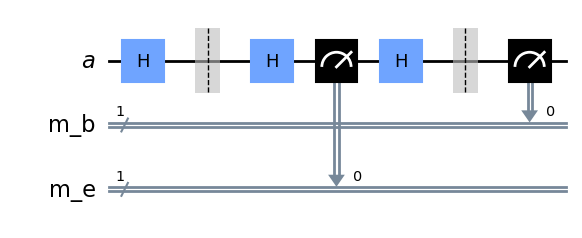

In [8]:
# Genera un circuito con BB84 para un solo qubit
# mensaje = Numero a enviar (0 o 1)
# eje_alice = Eje en el que medirá Alice (0 --> Z, 1 --> X)
# eje_bob = Eje en el que medirá Bob (0 --> Z, 1 --> X)
# eve = Si es True, Eve mirara los qubits antes de que lleguen a Alice y Bob
# eje_eve = Si Eve esta activa, eje en el que realiza la medicion (0 --> Z, 1 --> X)
def one_qubit_BB84(mensaje, eje_alice, eje_bob, eve = False, eje_eve = 0):
    qr_a = QuantumRegister(1,'a')
    cr_b = ClassicalRegister(1,'m_b')
    cr_e = ClassicalRegister(1,'m_e')
    qc_bb84 = QuantumCircuit(qr_a, cr_b, cr_e)

    # Alice escribe en el qubit el mensaje a enviar
    if mensaje == 1:
        qc_bb84.x(qr_a[0])

    # Alice codifica el qubit en el eje Z o X
    if eje_alice == 1:
        qc_bb84.h(qr_a[0])

    # Envio de Alice a Bob por un canal inseguro (puede haber un espia)
    qc_bb84.barrier()
    
    # Si hay un espia, mide el qubit en cierto eje
    if eve:
        if eje_eve == 1:
            qc_bb84.h(qr_a[0])
        qc_bb84.measure(0, cr_e[0])
        if eje_eve == 1:
            qc_bb84.h(qr_a[0])
        
    # El mensaje llega a Bob
    qc_bb84.barrier()

    # Bob mide el qubit en su eje de medicion
    if eje_bob == 1:
        qc_bb84.h(qr_a[0])
    qc_bb84.measure(0, cr_b[0])
    
    return qc_bb84

circuito_BB84 = one_qubit_BB84(0, 1, 0, True, 1)
circuito_BB84.draw('mpl')

In [40]:
# Ejecuta BB84 empleando varias veces el circuito anterior
# times = Numero de ejecuciones deseado
# eve = Determina si Eve aplica acciones de espionaje
# verbose = Si es True, da informacion por la salida estandar
# Devuelve la clave compartida generada y si se ha detectado un espia
def execute_BB84(times, eve = False, verbose = True):
    ejes_alice = []
    ejes_bob = []
    ejes_eve = []
    mediciones_alice = []
    mediciones_bob = []
    mediciones_eve = []
    detecta_espionaje = True
    # Ejecutamos times veces el circuito cuantico para un qubit
    for i in range(times):
        # Generamos el mensaje y los ejes de medida aleatoriamente
        mensaje_alice = random.randint(0, 1)
        eje_alice = random.randint(0, 1)
        eje_bob = random.randint(0, 1)
        eje_eve = random.randint(0, 1)
        # Creamos un circuito BB84 con un unico qubit
        qc_bb84 = one_qubit_BB84(mensaje_alice, eje_alice, eje_bob, eve, eje_eve)
        # Ejecutamos el circuito una vez
        counts = execute_circuit(qc_bb84, 1)
        # Obtenemos los resultados de la iteracion
        medicion = [int(c) for c in reversed((list(counts.keys())[0]).replace(" ",""))]
        # Almacenamos los resultados de la iteracion
        ejes_alice.append(eje_alice)
        mediciones_alice.append(mensaje_alice)
        ejes_bob.append(eje_bob)
        mediciones_bob.append(medicion[0])
        if eve:
            ejes_eve.append(eje_eve)
            mediciones_eve.append(medicion[1])

    # Alice y Bob publican en este punto las bases que han usado y se
    # quedan con aquellos qubits cuyas codificaciones hayan coincidido
    coincidencias = [0]*times
    clave_secreta_alice = []
    clave_secreta_bob = []
    clave_secreta_eve = []
    
    for i in range(times):
        if ejes_alice[i] == ejes_bob[i]:
            coincidencias[i] = 1
            clave_secreta_alice.append(mediciones_alice[i])
            clave_secreta_bob.append(mediciones_bob[i])
            # Si tenemos espia, esta tomara los valores con los que coincida con las bases
            if eve:
                if ejes_eve[i] == ejes_alice[i]:
                    clave_secreta_eve.append(mediciones_eve[i])
                else:
                    clave_secreta_eve.append(2) # Eve no conocera el valor de esta posicion

    if verbose:
        if times < 100:
            print('Ejes Alice:      ', ejes_alice)
            print('Ejes Bob:        ', ejes_bob)
            print('Coincidencias:   ', coincidencias)
            if eve:
                print('Ejes Eve:        ', ejes_eve)
            
            print('Mediciones Alice:', mediciones_alice)
            print('Mediciones Bob:  ', mediciones_bob)
            print('Clave secreta Alice:', clave_secreta_alice)
            print('Clave secreta Bob:  ', clave_secreta_bob)
            if eve:
                print('Clave secreta Eve:  ', clave_secreta_eve)
        else:
            print('Clave secreta Alice:', clave_secreta_alice)
    if clave_secreta_alice == clave_secreta_bob:
        detecta_espionaje = False
        if verbose:
            print('Las claves de Alice y Bob coinciden, por lo que no hay espionaje.')
    else:
        if verbose:
            print('Las claves de Alice y Bob NO coinciden: Eve ha sido detectada.')
            
    return clave_secreta_alice, detecta_espionaje

In [41]:
# Ejecucion sin espia
print('-------Ejecucion sin espionaje-------')
clave1, espia = execute_BB84(30, False)
# Ejecucion con espia
print('\n-------Ejecucion con espionaje-------')
clave2, espia = execute_BB84(30, True)

-------Ejecucion sin espionaje-------
Ejes Alice:       [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Ejes Bob:         [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Coincidencias:    [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Mediciones Alice: [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Mediciones Bob:   [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Clave secreta Alice: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Clave secreta Bob:   [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Las claves de Alice y Bob coinciden, por lo que no hay espionaje.

-------Ejecucion con espionaje-------
Ejes Alice:       [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Ejes Bob:         [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,

# B92

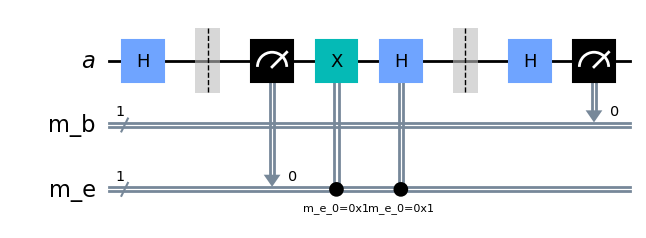

In [4]:
# Genera un circuito con BB84 para un solo qubit
# mensaje = Numero a enviar (0 o 1)
# eje_bob = Eje en el que medirá Bob (0 --> Z, 1 --> X)
# eve = Si es True, Eve mirara los qubits antes de que lleguen a Alice y Bob
# eje_eve = Si Eve esta activa, eje en el que realiza la medicion (0 --> Z, 1 --> X)
def one_qubit_B92(mensaje, eje_bob, eve = False, eje_eve = 0):
    qr_a = QuantumRegister(1,'a')
    cr_b = ClassicalRegister(1,'m_b')
    cr_e = ClassicalRegister(1,'m_e')
    qc_b92 = QuantumCircuit(qr_a, cr_b, cr_e)

    # Alice escribe en el qubit el mensaje a enviar, codificado como 0 o +
    if mensaje == 1:
        qc_b92.h(qr_a[0])

    # Envio de Alice a Bob por un canal inseguro (puede haber un espia)
    qc_b92.barrier()
    
    # Si hay un espia
    if eve:
        # Mide el qubit en cierto eje
        if eje_eve == 1:
            qc_b92.h(qr_a[0])
        qc_b92.measure(0, cr_e[0])
        # Trata de reconstruir la salida de la mejor manera posible
        # Si hemos leido en el eje Z
        if eje_eve == 0:
            # Si lee un 0, no hacemos nada, conservamos el ket{0}
            # Si hemos leido un 1, aplicamos XH para obtener ket{+}
            qc_b92.x(qr_a[0]).c_if(cr_e[0],1)
            qc_b92.h(qr_a[0]).c_if(cr_e[0],1)
        # Si hemos leido en el eje X
        else:
            # Si hemos leido un 0, Eve lo transforma en ket{+}
            qc_b92.h(qr_a[0]).c_if(cr_e[0],0)
            # Si hemos leido un 1, Eve lo transforma en ket{0}
            qc_b92.x(qr_a[0]).c_if(cr_e[0],1)
        
    # El mensaje llega a Bob
    qc_b92.barrier()

    # Bob decide si medir en el eje X o Z
    if eje_bob == 1:
        qc_b92.h(qr_a[0])

    # Bob aplica la medicion
    qc_b92.measure(qr_a[0],cr_b[0])

    return qc_b92
    
circuito_BB92 = one_qubit_B92(1, 1, True, 0)
circuito_BB92.draw('mpl')

In [13]:
# Ejecuta B92 empleando varias veces el circuito anterior
# times = Numero de pares EPR a usar
# eve = Determina si Eve aplica acciones de espionaje
# verbose = Si es True, da informacion por la salida estandar
# Devuelve la clave compartida generada y si se ha detectado un espia
def execute_B92(times, eve = False, verbose = True):
    ejes_bob = []
    ejes_eve = []
    mediciones_alice = []
    mediciones_bob = []
    mediciones_eve = []
    detecta_espionaje = True
    # Ejecutamos times veces el circuito cuantico para un qubit
    for i in range(times):
        # Generamos el mensaje y los ejes de medida aleatoriamente
        mensaje_alice = random.randint(0, 1)
        eje_bob = random.randint(0, 1)
        eje_eve = random.randint(0, 1)
        # Creamos un circuito B92 con un unico qubit
        qc_b92 = one_qubit_B92(mensaje_alice, eje_bob, eve, eje_eve)
        # Ejecutamos el circuito una vez
        counts = execute_circuit(qc_b92, 1)
        # Obtenemos los resultados de la iteracion
        medicion = [int(c) for c in reversed((list(counts.keys())[0]).replace(" ",""))]
        # Almacenamos los resultados de la iteracion
        mediciones_alice.append(mensaje_alice)
        ejes_bob.append(eje_bob)
        mediciones_bob.append(medicion[0])
        if eve:
            ejes_eve.append(eje_eve)
            mediciones_eve.append(medicion[1])
    
    # Hecha la medicion, Bob comprueba cuando mide un 0 al elegir el eje X, y
    # cuando mide un 1 en el eje Y. Estos seran los qubits usados para la clave.
    # Cuando eso ocurre, sabra que Alice le ha mandado realmente el valor contrario.
    
    acertados = [0]*times
    clave_secreta_alice = []
    clave_secreta_bob = []
    clave_secreta_eve = []
    clave_secreta_eve_completa = []
    
    for i in range(times):
        if mediciones_bob[i] == 1:
            acertados[i] = 1
            if ejes_bob[i] == 0:
                clave_secreta_bob.append(1)
            else:
                clave_secreta_bob.append(0)
                
    # Si tenemos Eve, esta guardara los valores de la clave que conozca y esperara
    # a que Bob diga los ejes que forman la clave
    if eve:
        for i in range(times):
            if mediciones_eve[i] == 1:
                if ejes_eve[i] == 0:
                    clave_secreta_eve_completa.append(1)
                else:
                    clave_secreta_eve_completa.append(0)
            else:
                clave_secreta_eve_completa.append(2)

    # Bob publica los qubits que ha acertado (y, por tanto, los que forman la clave)
    # Alice (y Eve) recuperan la clave a partir de ellos
    for i in range(times):
        if acertados[i] == 1:
            clave_secreta_alice.append(mediciones_alice[i])
            if eve:
                clave_secreta_eve.append(clave_secreta_eve_completa[i])

    if verbose:
        if times < 200:
            print('Mensaje Alice: ', mediciones_alice)
            print('Ejes Bob:      ', ejes_bob)
            print('Mediciones Bob:', mediciones_bob)
            print('Aciertos:      ', acertados)
            
            if eve:
                print('Ejes Eve:      ', ejes_eve)
                print('Mediciones Eve:', mediciones_eve)
            
            print('Clave secreta Alice:', clave_secreta_alice)
            print('Clave secreta Bob:  ', clave_secreta_bob)
            if eve:
                print('Clave secreta Eve:  ', clave_secreta_eve)
        else:
            print('Clave secreta Alice:', clave_secreta_alice)
    
    if clave_secreta_alice == clave_secreta_bob:
        detecta_espionaje = False
        if verbose:
            print('Las claves de Alice y Bob coinciden, por lo que no hay espionaje.')
    else:
        if verbose:
            print('Las claves de Alice y Bob NO coinciden: Eve ha sido detectada.')
  
    return clave_secreta_alice, detecta_espionaje

In [14]:
# Ejecucion sin espia
print('-------Ejecucion sin espionaje-------')
clave1, espia = execute_B92(100, False)
# Ejecucion con espia
print('\n-------Ejecucion con espionaje-------')
clave2, espia = execute_B92(100, True)

-------Ejecucion sin espionaje-------
Mensaje Alice:  [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
Ejes Bob:       [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Mediciones Bob: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Aciertos:  

# E91

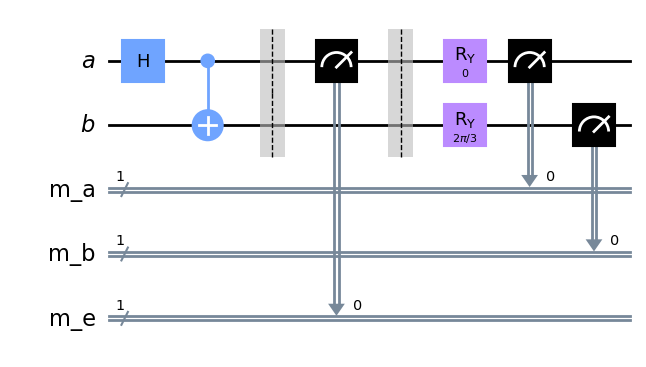

In [5]:
# Genera un circuito con E91 para un solo par EPR
# eje_alice = Eje en el que medirá Alice (0, 1 o 2)
# eje_bob = Eje en el que medirá Bob (0, 1 o 2)
# eve = Si es True, Eve mirara los qubits antes de que lleguen a Alice y Bob
# eje_eve = Si Eve esta activa, eje en el que realiza la medicion
def one_pair_E91(eje_alice, eje_bob, eve = False, eje_eve = 0):
    qr_a = QuantumRegister(1,'a')
    qr_b = QuantumRegister(1,'b')
    cr_a = ClassicalRegister(1,'m_a')
    cr_b = ClassicalRegister(1,'m_b')
    cr_e = ClassicalRegister(1,'m_e')
    qc_e91 = QuantumCircuit(qr_a, qr_b, cr_a, cr_b, cr_e)

    # Una entidad central genera pares EPR, y manda una parte a cada agente
    qc_e91.h(qr_a[0])
    qc_e91.cx(qr_a[0],qr_b[0])

    qc_e91.barrier() # La entidad envia una parte del par a cada interlocutor
    # Si Eve esta activo, se aplica espionaje
    # Eve mide el qubit de Alice en la base especificada
    if eve:
        qc_e91.measure(qr_a[0],cr_e[0])
    
    qc_e91.barrier()  # Los qubits llegan a su destino
    
    # Alice mide su qubit en un eje entre 0º, 120º y 240º
    qc_e91.ry(eje_alice*2*np.pi/3, qr_a[0])
    qc_e91.measure(qr_a[0],cr_a[0])

    # Bob mide su qubit en un eje entre 0º, 120º y 240º
    qc_e91.ry(eje_bob*2*np.pi/3, qr_b[0])
    qc_e91.measure(qr_b[0],cr_b[0])
    
    return qc_e91
    
circuito_E91 = one_pair_E91(0,1, True, 0)
circuito_E91.draw('mpl')

In [10]:
# Ejecuta E91 empleando varias veces el circuito anterior
# times = Numero de pares EPR a usar
# Devuelve la clave compartida generada y salidas por pantalla sobre la ejecucion
# del algoritmo y si se han encontrado potenciales espias
def execute_E91(times, eve = False, verbose = True):
    ejes_alice = []
    ejes_bob = []
    ejes_eve = []
    mediciones_alice = []
    mediciones_bob = []
    mediciones_eve = []
    detecta_espionaje = False
    # Ejecutamos times veces el circuito cuantico para un par EPR
    for i in range(times):
        # Generamos los ejes de medida aleatoriamente
        eje_alice = random.randint(0, 2)
        eje_bob = random.randint(0, 2)
        eje_eve = random.randint(0, 2)
        # Creamos un circuito E91 con un par EPR
        qc_e91 = one_pair_E91(eje_alice, eje_bob, eve, eje_eve)
        # Ejecutamos el circuito una vez
        counts = execute_circuit(qc_e91, 1)
        # Obtenemos los resultados de la iteracion
        medicion = [int(c) for c in reversed((list(counts.keys())[0]).replace(" ",""))]
        # Almacenamos los resultados de la iteracion
        ejes_alice.append(eje_alice)
        mediciones_alice.append(medicion[0])
        ejes_bob.append(eje_bob)
        mediciones_bob.append(medicion[1])
        if eve:
            ejes_eve.append(eje_eve)
            mediciones_eve.append(medicion[2])
    
    # En este punto, ambas partes publican sus bases y ven en qué qubits coinciden
    # Dichos qubits formaran la clave de cada uno
    coincidencias = [0]*times
    clave_secreta_alice = []
    clave_secreta_bob = []
    clave_secreta_eve = []
    
    for i in range(times):
        if ejes_alice[i] == ejes_bob[i]:
            coincidencias[i] = 1
            clave_secreta_alice.append(mediciones_alice[i])
            clave_secreta_bob.append(mediciones_bob[i])
            # Si tenemos espia, esta tomara los valores con los que coincida con las bases
            # De esta manera, espera obtener 1/3 de los valores de la clave
            if eve:
                if ejes_eve[i] == ejes_alice[i]:
                    clave_secreta_eve.append(mediciones_eve[i])
                else:
                    clave_secreta_eve.append(2) # Eve no conocera el valor de esta posicion

    # Calculamos el % de aciertos en bases no coincidentes
    n_ejes_diferentes = 0
    n_mediciones_iguales = 0
    for i in range(times):
        if coincidencias[i] == 0:
            n_ejes_diferentes += 1
            if mediciones_alice[i] == mediciones_bob[i]:
                n_mediciones_iguales += 1
    
    if verbose:
        if times < 100:
            print('Ejes Alice:      ', ejes_alice)
            print('Ejes Bob:        ', ejes_bob)
            print('Coincidencias:   ', coincidencias)
            
            print('Mediciones Alice:', mediciones_alice)
            print('Mediciones Bob:  ', mediciones_bob)
            print('Clave secreta Alice:', clave_secreta_alice)
            print('Clave secreta Bob:  ', clave_secreta_bob)
            if eve:
                print('Clave secreta Eve:  ', clave_secreta_eve)
        else:
            print('Clave secreta Alice:', clave_secreta_alice)
        porc_coincidencias = n_mediciones_iguales/n_ejes_diferentes
        print('% de coincidencias en ejes diferentes:', porc_coincidencias)
        
    # 5/16 es el punto medio entre 1/4 y 3/8. 
    #Lo consideraremos el umbral de peligro
    if porc_coincidencias > 5/16: 
        detecta_espionaje = True
        if verbose:
            print('Es probable que haya un espia, pues la probabilidad esta mas proxima a 3/8 que a 1/4.')
            
    return clave_secreta_alice, detecta_espionaje

In [11]:
# Ejecucion sin espia
print('-------Ejecucion sin espionaje-------')
clave, espia = execute_E91(1000, False)
# Ejecucion con espia
print('\n-------Ejecucion con espionaje-------')
clave, espia = execute_E91(1000, True)

-------Ejecucion sin espionaje-------
Clave secreta Alice: [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1